# Kinematic Reconstruction from Accelerometer Data

This notebook reconstructs velocity and displacement graphs for a user-defined axis ($X, Y, Z$) from raw acceleration data obtained via Phyphox.

## Initial Conditions
The reconstruction relies on the following initial values defined at the start of the execution:
* **Initial Velocity ($v_0$):** The velocity of the device at $t=0$.
* **Initial Position ($x_0$):** The position of the device at $t=0$.

## Mathematical Framework

The analysis proceeds in sequential steps: signal smoothing, followed by double integration.

**1. Signal Smoothing**
Raw accelerometer data contains high-frequency noise. To reduce this noise while preserving the shape and height of acceleration peaks, we apply a **Savitzky-Golay filter**.



For each data point $a_i$, the filter fits a polynomial $P(t)$ of order $k$ to a symmetric window of $2M+1$ neighboring points using the method of least squares. The smoothed value is the polynomial evaluated at the central point:

$$
a_i = P(t_i)
$$

**2. Velocity Reconstruction**
Velocity is derived by integrating the smoothed acceleration function over time and adding the initial velocity constant:

$$
v(t) = v_0 + \int_{0}^{t} a(\tau) \, d\tau
$$

**3. Displacement Reconstruction**
Displacement is derived by integrating the calculated velocity function over time and adding the initial position constant:

$$
x(t) = x_0 + \int_{0}^{t} v(\tau) \, d\tau
$$

**4. Discrete Numerical Approximation**
Since the sensor data is discrete with a sampling interval $\Delta t$, we approximate the integrals using the **Cumulative Trapezoidal Rule**. For the $n$-th data point:

$$
v_n \approx v_{n-1} + \frac{a_{n-1} + a_n}{2} \cdot \Delta t
$$

### Libraries Import

In [8]:
from scipy.integrate import cumulative_trapezoid
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Data Processing

In [9]:
# File and Axis Selection
FILE_NAME = "acceleration_data.csv"
RELEVANT_AXIS = "Linear Acceleration x (m/s^2)"

# Initial Conditions
V_INITIAL = 0.0
X_INITIAL = 0.0


# Importing via pandas (file in same directory)
df = pd.read_csv(FILE_NAME)

# Extracting relevant columns
time_raw = df["Time (s)"].values
acceleration_raw = df[RELEVANT_AXIS].values

# Normalizing time: ensuring start at t=0
time_normalized = time_raw - time_raw[0]

# Calculating dt
dt = np.mean(np.diff(time_normalized))

# Signal Smoothing via Savitzsky-Golay filter
acceleration_smooth = savgol_filter(acceleration_raw, window_length=81, polyorder=3)

### Visualizing Acceleration

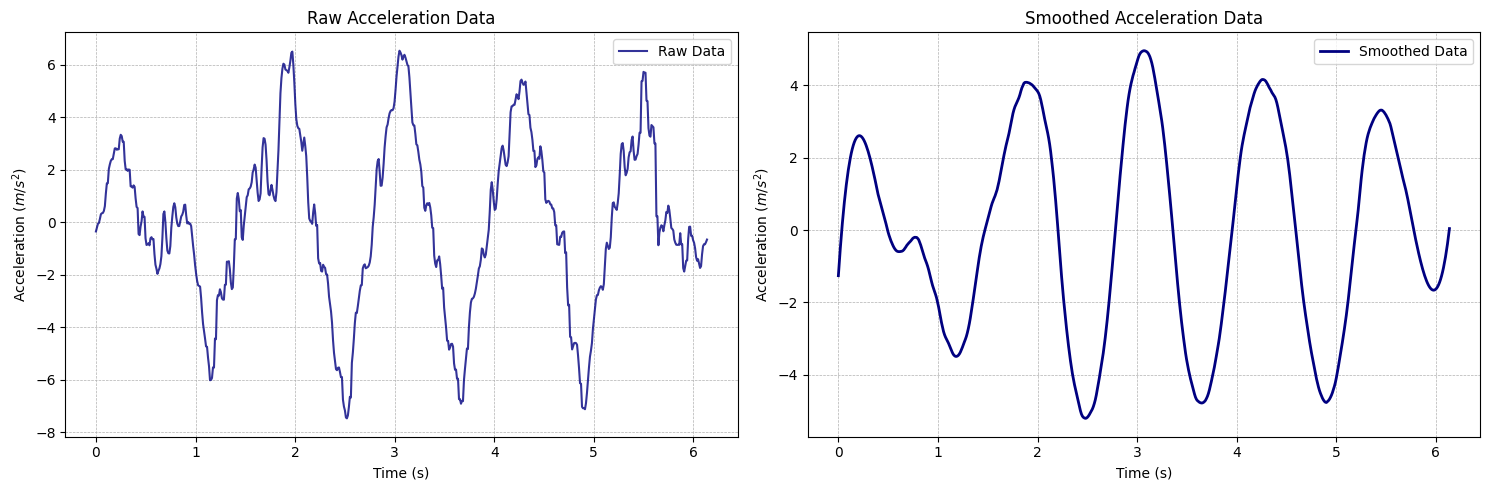

In [10]:
# Creating a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Raw Acceleration
ax1.plot(time_normalized, acceleration_raw, color="navy", label="Raw Data", alpha=0.8)
ax1.set_title("Raw Acceleration Data")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration ($m/s^2$)")
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()

# Plotting Smoothed Acceleration
ax2.plot(time_normalized, acceleration_smooth, color="navy", label="Smoothed Data", linewidth=2)
ax2.set_title("Smoothed Acceleration Data")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Acceleration ($m/s^2$)")
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

### Velocity Reconstruction

In [11]:
# Integration of acceleration to get velocity
velocity_integrated = cumulative_trapezoid(acceleration_smooth, dx=dt, initial=0)

# Add the initial velocity
velocity_final = velocity_integrated + X_INITIAL

### Visualizing Velocity

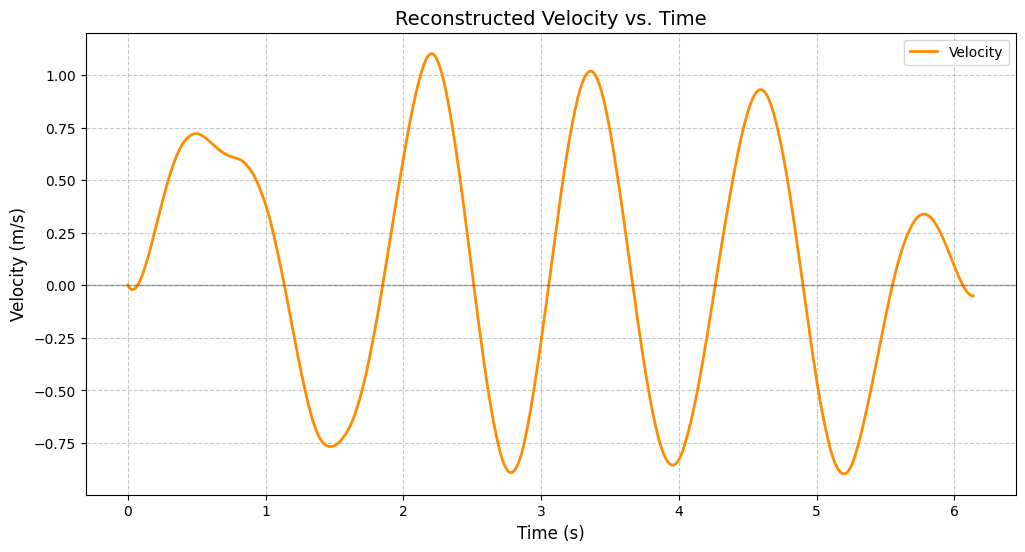

In [12]:
# Plotting the velocity
plt.figure(figsize=(12, 6))
plt.plot(time_normalized, velocity_final, color="darkorange", linewidth=2, label="Velocity")
plt.title("Reconstructed Velocity vs. Time", fontsize=14)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Velocity (m/s)", fontsize=12)
plt.axhline(0, color="black", linewidth=1, linestyle="-", alpha=0.3)
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

### Displacement Reconstruction

In [13]:
# Integration of velocity to get displacement
displacement_integrated = cumulative_trapezoid(velocity_final, dx=dt, initial=0)

# Add the initial displacement
displacement_final = displacement_integrated + X_INITIAL

### Visualizing Displacement

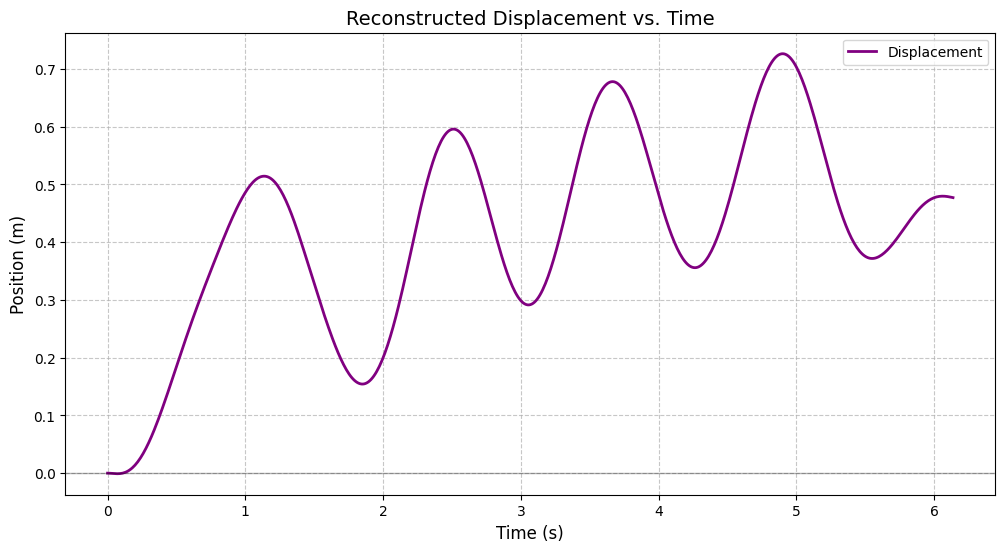

In [14]:
# Plotting the displacement
plt.figure(figsize=(12, 6))
plt.plot(time_normalized, displacement_final, color="purple", linewidth=2, label="Displacement")
plt.title("Reconstructed Displacement vs. Time", fontsize=14)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Position (m)", fontsize=12)
plt.axhline(0, color="black", linewidth=1, linestyle="-", alpha=0.3)
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.legend()
plt.show()